# Responsible AI: Driver Notebook

In [ ]:
# Complete AI Fairness Analysis Implementation
# Ready for Google Colab execution

# =======================================
# PART 1: SETUP AND INSTALLATIONS
# =======================================

# Install required packages (run this first in Colab)
"""
!pip install fairlearn aequitas shap pandas numpy scikit-learn matplotlib seaborn plotly
"""
!pip install fairlearn aequitas shap pandas numpy scikit-learn matplotlib seaborn plotly

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━

In [ ]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Fairness and ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Fairlearn imports
from fairlearn.metrics import MetricFrame, demographic_parity_difference, demographic_parity_ratio
from fairlearn.metrics import equalized_odds_difference, selection_rate
from fairlearn.postprocessing import ThresholdOptimizer

# SHAP for explainability
import shap

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:
# =======================================
# PART 2: DATASET GENERATION
# =======================================

def generate_biased_hiring_dataset(n_samples=1000):
    """
    Generate a synthetic hiring dataset with intentional bias

    Parameters:
    n_samples (int): Number of candidates to generate

    Returns:
    pandas.DataFrame: Complete dataset with features and biased target
    """

    print(f" Generating {n_samples} candidate records...")

    # Set random seed for reproducibility
    np.random.seed(42)

    # Generate demographic features
    genders = np.random.choice(['Male', 'Female', 'Non-binary'],
                              size=n_samples,
                              p=[0.55, 0.40, 0.05])  # Slightly male-skewed

    ethnicities = np.random.choice(['White', 'Black', 'Hispanic', 'Asian', 'Other'],
                                  size=n_samples,
                                  p=[0.60, 0.15, 0.12, 0.10, 0.03])  # US demographic approximation

    # Generate legitimate professional qualifications
    experience_years = np.random.gamma(3, 2, n_samples).astype(int)  # 0-15 years, realistic distribution
    experience_years = np.clip(experience_years, 0, 15)

    education_levels = np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'],
                                       size=n_samples,
                                       p=[0.20, 0.50, 0.25, 0.05])

    # Skills and performance scores (1-10 scale)
    skills_score = np.random.normal(6.5, 1.5, n_samples)
    skills_score = np.clip(skills_score, 1, 10)

    previous_performance = np.random.normal(7, 1.2, n_samples)
    previous_performance = np.clip(previous_performance, 1, 10)

    # Additional realistic features
    certifications = np.random.poisson(2, n_samples)  # Number of professional certifications
    leadership_exp = np.random.binomial(1, 0.3, n_samples)  # Leadership experience (0/1)

    # Create base qualification score (what hiring SHOULD be based on)
    base_qualification = (
        0.30 * (experience_years / 15) +  # Experience weight
        0.25 * (skills_score / 10) +      # Skills weight
        0.20 * (previous_performance / 10) + # Performance weight
        0.15 * (certifications / 5) +     # Certifications weight
        0.10 * leadership_exp              # Leadership weight
    )

    # Add education bonus
    education_bonus = {
        'High School': 0.0,
        'Bachelor': 0.1,
        'Master': 0.2,
        'PhD': 0.3
    }

    for i, edu in enumerate(education_levels):
        base_qualification[i] += education_bonus[edu]

    # Add noise to make it realistic
    base_qualification += np.random.normal(0, 0.1, n_samples)
    base_qualification = np.clip(base_qualification, 0, 1)

    # NOW ADD THE BIAS (this is the problematic part)
    bias_factor = np.zeros(n_samples)

    for i in range(n_samples):
        # Bias favoring Male + White candidates
        if genders[i] == 'Male':
            bias_factor[i] += 0.15  # Male advantage
        elif genders[i] == 'Female':
            bias_factor[i] -= 0.10  # Female penalty
        else:  # Non-binary
            bias_factor[i] -= 0.20  # Non-binary penalty

        if ethnicities[i] == 'White':
            bias_factor[i] += 0.12  # White advantage
        elif ethnicities[i] == 'Asian':
            bias_factor[i] += 0.05  # Slight Asian advantage
        else:  # Black, Hispanic, Other
            bias_factor[i] -= 0.08  # Minority penalty

    # Create biased final score
    biased_score = base_qualification + bias_factor
    biased_score = np.clip(biased_score, 0, 1)

    # Convert to hiring tiers
    hiring_tier = np.where(biased_score >= 0.7, 'Tier-1',
                          np.where(biased_score >= 0.4, 'Tier-2', 'Tier-3'))

    # Create DataFrame
    df = pd.DataFrame({
        'gender': genders,
        'ethnicity': ethnicities,
        'experience_years': experience_years,
        'education_level': education_levels,
        'skills_score': skills_score,
        'previous_performance': previous_performance,
        'certifications': certifications,
        'leadership_exp': leadership_exp,
        'base_qualification': base_qualification,
        'bias_factor': bias_factor,
        'final_score': biased_score,
        'hiring_tier': hiring_tier
    })

    print("Dataset generated successfully!")
    print(f"Shape: {df.shape}")
    print(f"Tier distribution:\n{df['hiring_tier'].value_counts()}")
    print(f"Gender distribution:\n{df['gender'].value_counts()}")
    print(f"Ethnicity distribution:\n{df['ethnicity'].value_counts()}")

    return df

In [ ]:
# Generate the dataset
df = generate_biased_hiring_dataset(1000)

 Generating 1000 candidate records...
Dataset generated successfully!
Shape: (1000, 12)
Tier distribution:
hiring_tier
Tier-1    497
Tier-2    399
Tier-3    104
Name: count, dtype: int64
Gender distribution:
gender
Male          559
Female        395
Non-binary     46
Name: count, dtype: int64
Ethnicity distribution:
ethnicity
White       570
Black       172
Hispanic    127
Asian        96
Other        35
Name: count, dtype: int64


In [ ]:
# Display basic statistics
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())


DATASET OVERVIEW
       gender ethnicity  experience_years education_level  skills_score  \
0        Male     White                 2        Bachelor      6.696598   
1  Non-binary     White                 3        Bachelor      6.270783   
2      Female     Asian                 8        Bachelor      8.762371   
3      Female     Black                 3        Bachelor      5.603953   
4        Male  Hispanic                 5        Bachelor      5.768489   

   previous_performance  certifications  leadership_exp  base_qualification  \
0              8.438239               1               1            0.568586   
1              7.957672               4               0            0.551032   
2              5.587994               3               0            0.640208   
3              6.877440               3               1            0.637323   
4              8.187939               1               0            0.376496   

   bias_factor  final_score hiring_tier  
0         0.27

In [ ]:
# =======================================
# PART 3: EXPLORATORY DATA ANALYSIS
# =======================================

def analyze_bias_in_data(df):
    """Analyze and visualize bias in the generated dataset"""

    print("\n" + "="*50)
    print("BIAS ANALYSIS")
    print("="*50)

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Hiring rates by gender
    gender_hiring = pd.crosstab(df['gender'], df['hiring_tier'], normalize='index') * 100
    gender_hiring.plot(kind='bar', ax=axes[0,0], title='Hiring Rates by Gender (%)')
    axes[0,0].set_ylabel('Percentage')
    axes[0,0].legend(title='Hiring Tier')
    axes[0,0].tick_params(axis='x', rotation=45)

    # 2. Hiring rates by ethnicity
    ethnicity_hiring = pd.crosstab(df['ethnicity'], df['hiring_tier'], normalize='index') * 100
    ethnicity_hiring.plot(kind='bar', ax=axes[0,1], title='Hiring Rates by Ethnicity (%)')
    axes[0,1].set_ylabel('Percentage')
    axes[0,1].legend(title='Hiring Tier')
    axes[0,1].tick_params(axis='x', rotation=45)

    # 3. Qualification scores by gender
    df.boxplot(column='base_qualification', by='gender', ax=axes[1,0])
    axes[1,0].set_title('Base Qualification by Gender')
    axes[1,0].set_ylabel('Qualification Score')

    # 4. Final scores by gender (showing bias effect)
    df.boxplot(column='final_score', by='gender', ax=axes[1,1])
    axes[1,1].set_title('Final Score by Gender (After Bias)')
    axes[1,1].set_ylabel('Final Score')

    plt.tight_layout()
    plt.show()

    # Print bias statistics
    print("\n BIAS DETECTION RESULTS:")
    print("-" * 30)

    # Tier-1 hiring rates by group
    tier1_rates = df[df['hiring_tier'] == 'Tier-1'].groupby('gender').size() / df.groupby('gender').size()
    print(f"Tier-1 Hiring Rates by Gender:")
    for gender, rate in tier1_rates.items():
        print(f"  {gender}: {rate:.2%}")

    tier1_rates_eth = df[df['hiring_tier'] == 'Tier-1'].groupby('ethnicity').size() / df.groupby('ethnicity').size()
    print(f"\nTier-1 Hiring Rates by Ethnicity:")
    for ethnicity, rate in tier1_rates_eth.items():
        print(f"  {ethnicity}: {rate:.2%}")

    # Show the bias factor impact
    print(f"\n Bias Factor Statistics:")
    print(f"Mean bias by gender:\n{df.groupby('gender')['bias_factor'].mean()}")
    print(f"\nMean bias by ethnicity:\n{df.groupby('ethnicity')['bias_factor'].mean()}")


BIAS ANALYSIS


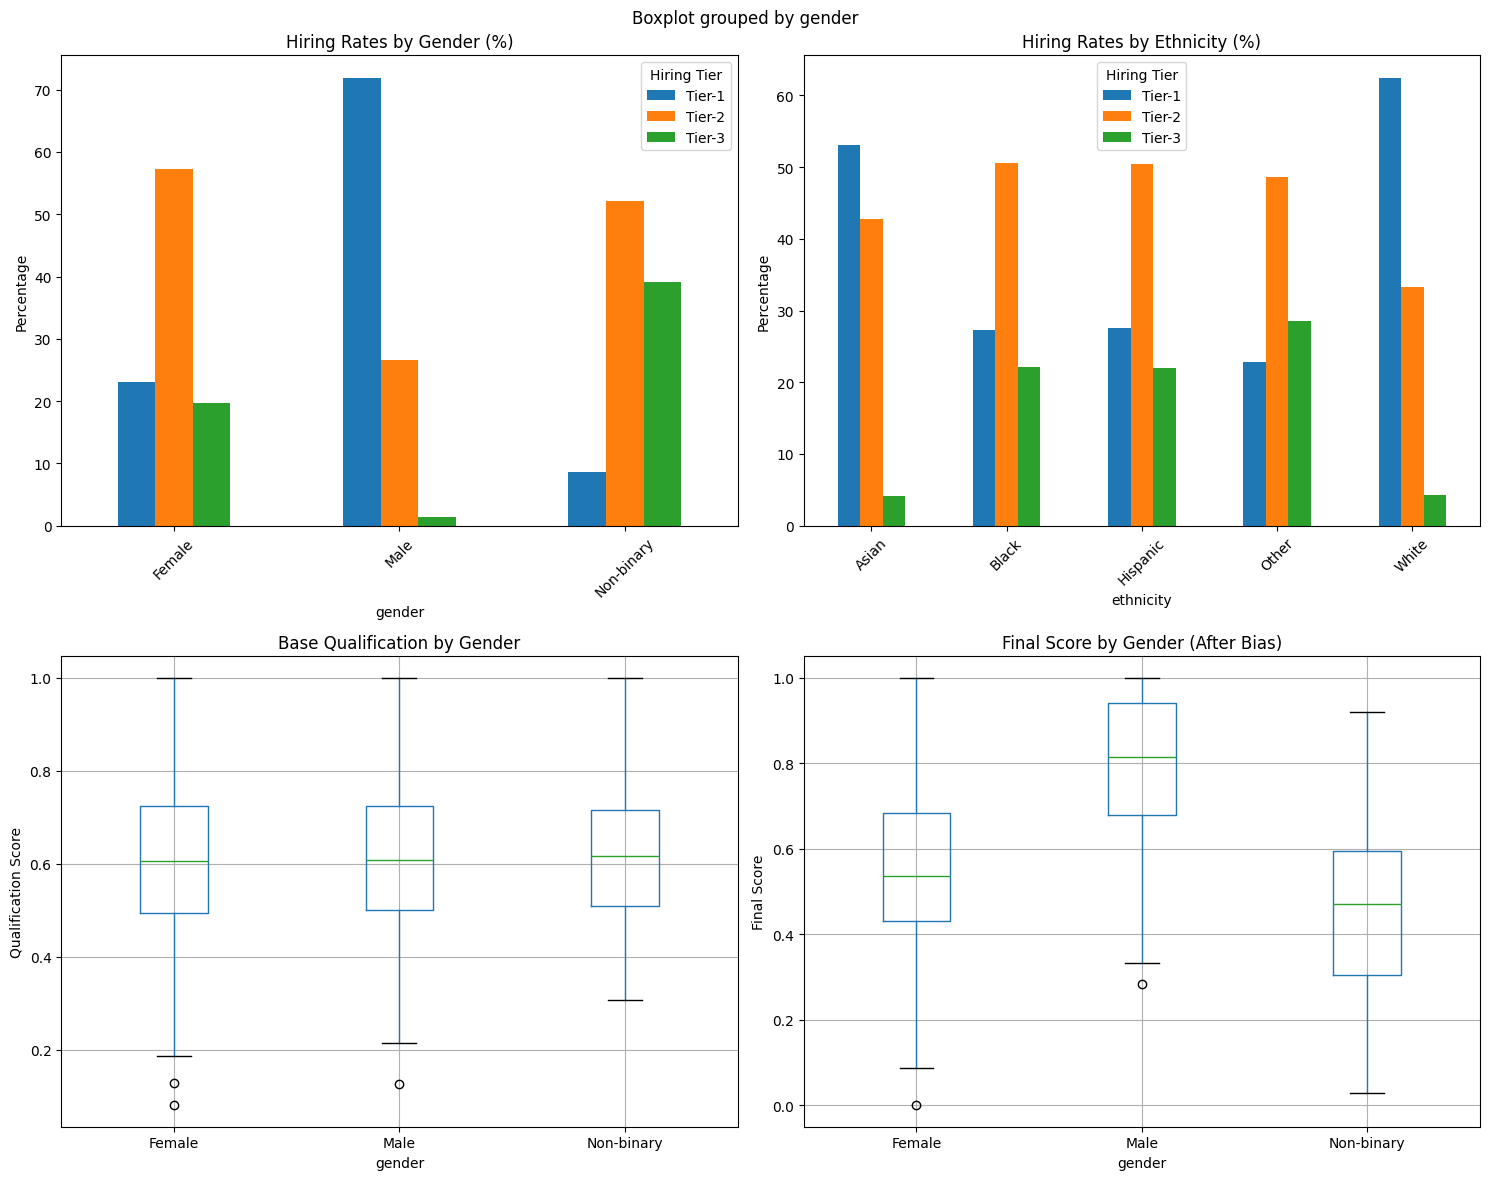


 BIAS DETECTION RESULTS:
------------------------------
Tier-1 Hiring Rates by Gender:
  Female: 23.04%
  Male: 71.91%
  Non-binary: 8.70%

Tier-1 Hiring Rates by Ethnicity:
  Asian: 53.12%
  Black: 27.33%
  Hispanic: 27.56%
  Other: 22.86%
  White: 62.46%

 Bias Factor Statistics:
Mean bias by gender:
gender
Female       -0.052886
Male          0.197871
Non-binary   -0.175870
Name: bias_factor, dtype: float64

Mean bias by ethnicity:
ethnicity
Asian       0.092708
Black      -0.049767
Hispanic   -0.051654
Other      -0.045714
White       0.156930
Name: bias_factor, dtype: float64


In [ ]:
# Run bias analysis
analyze_bias_in_data(df)

In [ ]:
# =======================================
# PART 4: MACHINE LEARNING MODEL TRAINING
# =======================================

def prepare_data_for_ml(df):
    """Prepare data for machine learning"""

    print("\n" + "="*50)
    print("PREPARING DATA FOR ML")
    print("="*50)

    # Separate features and target
    feature_cols = ['experience_years', 'skills_score', 'previous_performance',
                   'certifications', 'leadership_exp', 'gender', 'ethnicity', 'education_level']

    X = df[feature_cols].copy()

    # Convert hiring tier to binary (Tier-1 = 1, others = 0) for simplicity
    y = (df['hiring_tier'] == 'Tier-1').astype(int)

    # Encode categorical variables
    le_gender = LabelEncoder()
    le_ethnicity = LabelEncoder()
    le_education = LabelEncoder()

    X['gender_encoded'] = le_gender.fit_transform(X['gender'])
    X['ethnicity_encoded'] = le_ethnicity.fit_transform(X['ethnicity'])
    X['education_encoded'] = le_education.fit_transform(X['education_level'])

    # Create feature matrix (including sensitive attributes for now)
    X_encoded = X[['experience_years', 'skills_score', 'previous_performance',
                   'certifications', 'leadership_exp', 'gender_encoded',
                   'ethnicity_encoded', 'education_encoded']]

    # Also create "fair" feature matrix (without sensitive attributes)
    X_fair = X[['experience_years', 'skills_score', 'previous_performance',
                'certifications', 'leadership_exp', 'education_encoded']]

    # Prepare sensitive features for fairness analysis
    sensitive_features = df[['gender', 'ethnicity']]

    print(f" Data prepared successfully!")
    print(f" Feature matrix shape: {X_encoded.shape}")
    print(f" Target distribution: {y.value_counts().to_dict()}")

    return X_encoded, X_fair, y, sensitive_features, (le_gender, le_ethnicity, le_education)

In [ ]:
# Prepare data
X_encoded, X_fair, y, sensitive_features, encoders = prepare_data_for_ml(df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)
X_train_fair, X_test_fair, _, _ = train_test_split(X_fair, y, test_size=0.3, random_state=42, stratify=y)

# Get corresponding sensitive features for train/test splits
sensitive_train = sensitive_features.iloc[X_train.index]
sensitive_test = sensitive_features.iloc[X_test.index]

# Train models
print("\n Training ML models...")


PREPARING DATA FOR ML
 Data prepared successfully!
 Feature matrix shape: (1000, 8)
 Target distribution: {0: 503, 1: 497}

 Training ML models...


In [ ]:
# Biased model (includes sensitive attributes)
biased_model = RandomForestClassifier(n_estimators=100, random_state=42)
biased_model.fit(X_train, y_train)
y_pred_biased = biased_model.predict(X_test)

# Fair model (excludes sensitive attributes)
fair_model = RandomForestClassifier(n_estimators=100, random_state=42)
fair_model.fit(X_train_fair, y_train)
y_pred_fair = fair_model.predict(X_test_fair)

print(" Models trained successfully!")

 Models trained successfully!


In [ ]:
# =======================================
# PART 5: FAIRLEARN ANALYSIS
# =======================================

def fairlearn_analysis(y_test, y_pred, sensitive_test, model_name="Model"):
    """Perform comprehensive Fairlearn analysis"""

    print(f"\n" + "="*50)
    print(f"FAIRLEARN ANALYSIS - {model_name.upper()}")
    print("="*50)

    # Create MetricFrame for detailed analysis
    mf = MetricFrame(
        metrics={
            "accuracy": accuracy_score,
            "selection_rate": selection_rate,
        },
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=sensitive_test
    )

    print(" Performance by Group:")
    print(mf.by_group)

    print(f"\n Overall Metrics:")
    print(f"Overall Accuracy: {mf.overall['accuracy']:.3f}")
    print(f"Overall Selection Rate: {mf.overall['selection_rate']:.3f}")

    # Calculate fairness metrics
    print(f"\n  Fairness Metrics:")

    # Gender fairness
    gender_dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test['gender'])
    gender_dp_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test['gender'])
    gender_eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test['gender'])

    print(f"Gender - Demographic Parity Difference: {gender_dp_diff:.3f}")
    print(f"Gender - Demographic Parity Ratio: {gender_dp_ratio:.3f}")
    print(f"Gender - Equalized Odds Difference: {gender_eo_diff:.3f}")

    # Ethnicity fairness
    ethnicity_dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test['ethnicity'])
    ethnicity_dp_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test['ethnicity'])
    ethnicity_eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test['ethnicity'])

    print(f"Ethnicity - Demographic Parity Difference: {ethnicity_dp_diff:.3f}")
    print(f"Ethnicity - Demographic Parity Ratio: {ethnicity_dp_ratio:.3f}")
    print(f"Ethnicity - Equalized Odds Difference: {ethnicity_eo_diff:.3f}")

    # Interpretation
    print(f"\n Interpretation:")
    if abs(gender_dp_diff) > 0.1:
        print(f"  GENDER BIAS DETECTED: {abs(gender_dp_diff):.1%} difference in selection rates")
    else:
        print(" Gender fairness looks good")

    if abs(ethnicity_dp_diff) > 0.1:
        print(f"  ETHNICITY BIAS DETECTED: {abs(ethnicity_dp_diff):.1%} difference in selection rates")
    else:
        print(" Ethnicity fairness looks good")

    return mf

In [ ]:
# Analyze both models
mf_biased = fairlearn_analysis(y_test, y_pred_biased, sensitive_test, "Biased Model")
mf_fair = fairlearn_analysis(y_test, y_pred_fair, sensitive_test, "Fair Model")


FAIRLEARN ANALYSIS - BIASED MODEL
 Performance by Group:
                      accuracy  selection_rate
gender     ethnicity                          
Female     Asian      0.818182        0.090909
           Black      0.875000        0.062500
           Hispanic   0.947368        0.052632
           Other      1.000000        0.000000
           White      0.776316        0.223684
Male       Asian      0.647059        0.352941
           Black      0.878788        0.424242
           Hispanic   0.687500        0.437500
           Other      1.000000        0.400000
           White      0.869565        0.978261
Non-binary Asian      0.000000        1.000000
           Black      0.500000        0.500000
           Hispanic   1.000000        0.000000
           Other      1.000000        0.000000
           White      0.500000        0.666667

 Overall Metrics:
Overall Accuracy: 0.820
Overall Selection Rate: 0.483

  Fairness Metrics:
Gender - Demographic Parity Difference: 0.569
Gen

In [ ]:
# =======================================
# PART 6: THRESHOLD OPTIMIZER
# =======================================

def apply_threshold_optimizer(model, X_train, y_train, X_test, y_test, sensitive_train, sensitive_test):
    """Apply ThresholdOptimizer to mitigate bias"""

    print("\n" + "="*50)
    print("THRESHOLD OPTIMIZER")
    print("="*50)

    # Apply ThresholdOptimizer
    print(" Applying ThresholdOptimizer...")

    threshold_optimizer = ThresholdOptimizer(
        estimator=model,
        constraints="demographic_parity",
        prefit=True
    )

    # Fit the optimizer
    threshold_optimizer.fit(X_train, y_train, sensitive_features=sensitive_train['gender'])

    # Get optimized predictions
    y_pred_optimized = threshold_optimizer.predict(X_test, sensitive_features=sensitive_test['gender'])

    print(" Optimization complete!")

    # Compare before and after
    print("\n BEFORE vs AFTER Comparison:")
    print("-" * 40)

    # Original predictions
    original_accuracy = accuracy_score(y_test, model.predict(X_test))
    original_dp_diff = demographic_parity_difference(y_test, model.predict(X_test),
                                                    sensitive_features=sensitive_test['gender'])

    # Optimized predictions
    optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
    optimized_dp_diff = demographic_parity_difference(y_test, y_pred_optimized,
                                                     sensitive_features=sensitive_test['gender'])

    print(f"Original Model:")
    print(f"  Accuracy: {original_accuracy:.3f}")
    print(f"  Demographic Parity Difference: {original_dp_diff:.3f}")

    print(f"\nOptimized Model:")
    print(f"  Accuracy: {optimized_accuracy:.3f}")
    print(f"  Demographic Parity Difference: {optimized_dp_diff:.3f}")

    print(f"\nImprovement:")
    print(f"  Accuracy Change: {optimized_accuracy - original_accuracy:+.3f}")
    print(f"  Bias Reduction: {abs(optimized_dp_diff) - abs(original_dp_diff):+.3f}")
    print(f"  Bias Reduction %: {(1 - abs(optimized_dp_diff)/abs(original_dp_diff))*100:.1f}%")

    return threshold_optimizer, y_pred_optimized

In [ ]:
# Apply threshold optimization to biased model
threshold_optimizer, y_pred_optimized = apply_threshold_optimizer(
    biased_model, X_train, y_train, X_test, y_test, sensitive_train, sensitive_test
)


THRESHOLD OPTIMIZER
 Applying ThresholdOptimizer...
 Optimization complete!

 BEFORE vs AFTER Comparison:
----------------------------------------
Original Model:
  Accuracy: 0.820
  Demographic Parity Difference: 0.569

Optimized Model:
  Accuracy: 0.633
  Demographic Parity Difference: 0.199

Improvement:
  Accuracy Change: -0.187
  Bias Reduction: -0.370
  Bias Reduction %: 65.0%


In [ ]:
# =======================================
# PART 7: SHAP ANALYSIS
# =======================================

def shap_analysis(model, X_train, X_test, feature_names, sensitive_test):
    """Perform SHAP analysis to understand feature importance and bias"""

    print("\n" + "="*50)
    print("SHAP EXPLAINABILITY ANALYSIS")
    print("="*50)

    print(" Computing SHAP values...")

    try:
        # Create SHAP explainer
        explainer = shap.TreeExplainer(model)

        # Calculate SHAP values for test set (sample for speed)
        sample_size = min(100, len(X_test))
        X_sample = X_test.iloc[:sample_size].copy()
        shap_values = explainer.shap_values(X_sample)

        # For binary classification, we want the positive class SHAP values
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Positive class

        print(" SHAP values computed!")

        # Feature importance
        feature_importance = np.abs(shap_values).mean(axis=0)
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)

        print("\n Feature Importance (SHAP):")
        print(importance_df)

        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('SHAP Analysis Results', fontsize=14, fontweight='bold')

        # 1. Feature importance bar plot
        axes[0,0].barh(range(len(importance_df)), importance_df['importance'])
        axes[0,0].set_yticks(range(len(importance_df)))
        axes[0,0].set_yticklabels(importance_df['feature'])
        axes[0,0].set_xlabel('Mean |SHAP value|')
        axes[0,0].set_title('Feature Importance')
        axes[0,0].invert_yaxis()

        # 2. SHAP summary plot (create manually to avoid issues)
        # Calculate feature impact for visualization
        shap_mean = np.abs(shap_values).mean(axis=0)
        shap_std = np.abs(shap_values).std(axis=0)

        axes[0,1].barh(range(len(feature_names)), shap_mean, xerr=shap_std, capsize=5)
        axes[0,1].set_yticks(range(len(feature_names)))
        axes[0,1].set_yticklabels(feature_names)
        axes[0,1].set_xlabel('Mean |SHAP value| ± Std')
        axes[0,1].set_title('SHAP Value Distribution')
        axes[0,1].invert_yaxis()

        # 3. SHAP values by gender (if gender is a feature)
        if 'gender_encoded' in feature_names:
            gender_idx = feature_names.index('gender_encoded')

            # Get gender labels for the sample - fix the indexing issue
            sample_indices = X_sample.index
            gender_sample = sensitive_test.loc[sample_indices, 'gender'].values

            # Create data for box plot manually
            gender_shap_data = []
            gender_labels = []

            for gender in np.unique(gender_sample):
                gender_mask = gender_sample == gender
                gender_shap_values = shap_values[gender_mask, gender_idx]
                gender_shap_data.extend(gender_shap_values)
                gender_labels.extend([gender] * len(gender_shap_values))

            # Create box plot manually
            unique_genders = np.unique(gender_labels)
            box_data = [np.array(gender_shap_data)[np.array(gender_labels) == gender]
                       for gender in unique_genders]

            axes[1,0].boxplot(box_data, labels=unique_genders)
            axes[1,0].set_title('SHAP Values for Gender Feature by Gender Group')
            axes[1,0].set_ylabel('SHAP Value')
            axes[1,0].tick_params(axis='x', rotation=45)

        # 4. Individual prediction explanation (waterfall style)
        # Create a simple bar chart showing SHAP values for first prediction
        first_shap = shap_values[0]
        positive_contrib = first_shap[first_shap > 0]
        negative_contrib = first_shap[first_shap < 0]
        positive_features = [feature_names[i] for i in range(len(first_shap)) if first_shap[i] > 0]
        negative_features = [feature_names[i] for i in range(len(first_shap)) if first_shap[i] < 0]

        # Plot top contributors
        top_positive = sorted(zip(positive_features, positive_contrib), key=lambda x: x[1], reverse=True)[:5]
        top_negative = sorted(zip(negative_features, negative_contrib), key=lambda x: x[1])[:5]

        if top_positive or top_negative:
            features_plot = [x[0] for x in top_positive] + [x[0] for x in top_negative]
            values_plot = [x[1] for x in top_positive] + [x[1] for x in top_negative]
            colors = ['green'] * len(top_positive) + ['red'] * len(top_negative)

            axes[1,1].barh(range(len(features_plot)), values_plot, color=colors)
            axes[1,1].set_yticks(range(len(features_plot)))
            axes[1,1].set_yticklabels(features_plot)
            axes[1,1].set_xlabel('SHAP Value')
            axes[1,1].set_title('Top Feature Contributions (First Prediction)')
            axes[1,1].axvline(x=0, color='black', linestyle='-', alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Analyze bias in SHAP values
        print("\n BIAS ANALYSIS IN SHAP VALUES:")
        print("-" * 40)

        # Check if sensitive features have high importance
        sensitive_features_importance = []
        for feat in ['gender_encoded', 'ethnicity_encoded']:
            if feat in feature_names:
                idx = feature_names.index(feat)
                importance = feature_importance[idx]
                sensitive_features_importance.append((feat, importance))
                print(f"{feat}: {importance:.4f}")

        # Sort all features by importance
        print(f"\nTop 5 Most Important Features:")
        for i, (feat, imp) in enumerate(importance_df.head().values):
            status = " SENSITIVE" if feat in ['gender_encoded', 'ethnicity_encoded'] else " LEGITIMATE"
            print(f"{i+1}. {feat}: {imp:.4f} {status}")

        return shap_values, explainer

    except Exception as e:
        print(f" Error in SHAP analysis: {str(e)}")
        print(" Proceeding with basic feature importance from Random Forest...")

        # Fallback to basic feature importance
        feature_importance = model.feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)

        print("\n Feature Importance (Random Forest):")
        print(importance_df)

        # Simple visualization
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(importance_df)), importance_df['importance'])
        plt.yticks(range(len(importance_df)), importance_df['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Random Forest Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        return None, None


SHAP EXPLAINABILITY ANALYSIS
 Computing SHAP values...
 SHAP values computed!
 Error in SHAP analysis: Per-column arrays must each be 1-dimensional
 Proceeding with basic feature importance from Random Forest...

 Feature Importance (Random Forest):
                feature  importance
5        gender_encoded    0.211408
1          skills_score    0.165757
2  previous_performance    0.159441
0      experience_years    0.146579
6     ethnicity_encoded    0.126317
7     education_encoded    0.083194
3        certifications    0.072896
4        leadership_exp    0.034408


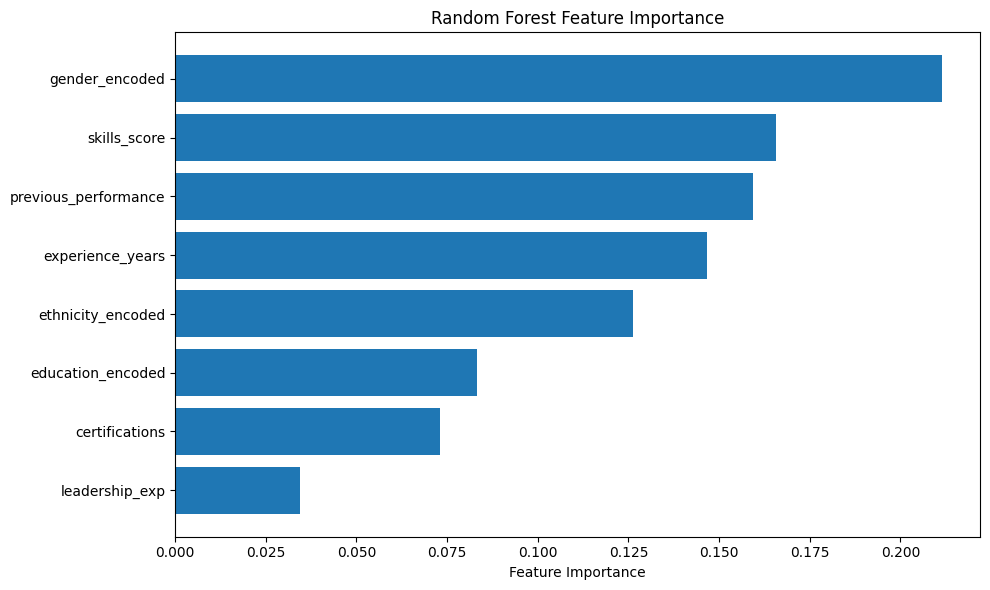

In [ ]:
# Perform SHAP analysis on biased model
feature_names = ['experience_years', 'skills_score', 'previous_performance',
                'certifications', 'leadership_exp', 'gender_encoded',
                'ethnicity_encoded', 'education_encoded']

shap_values, explainer = shap_analysis(biased_model, X_train, X_test, feature_names, sensitive_test)

In [ ]:
# =======================================
# PART 8: COMPREHENSIVE REPORT
# =======================================

def generate_final_report(df, mf_biased, mf_fair, y_test, y_pred_biased, y_pred_optimized, sensitive_test):
    """Generate a comprehensive fairness report"""

    print("\n" + "="*60)
    print("COMPREHENSIVE FAIRNESS ANALYSIS REPORT")
    print("="*60)

    print(" EXECUTIVE SUMMARY")
    print("-" * 20)

    # Dataset summary
    print(f"Dataset Size: {len(df):,} candidates")
    print(f"Features: {len(df.columns)} total features")
    print(f"Sensitive Attributes: Gender, Ethnicity")
    print(f"Target: Tier-1 hiring recommendation")

    # Model performance summary
    biased_accuracy = accuracy_score(y_test, y_pred_biased)
    optimized_accuracy = accuracy_score(y_test, y_pred_optimized)

    biased_dp_diff = demographic_parity_difference(y_test, y_pred_biased,
                                                  sensitive_features=sensitive_test['gender'])
    optimized_dp_diff = demographic_parity_difference(y_test, y_pred_optimized,
                                                     sensitive_features=sensitive_test['gender'])

    print(f"\n MODEL PERFORMANCE COMPARISON")
    print("-" * 35)
    print(f"{'Metric':<25} {'Biased Model':<15} {'Optimized Model':<15} {'Change':<10}")
    print("-" * 65)
    print(f"{'Accuracy':<25} {biased_accuracy:<15.3f} {optimized_accuracy:<15.3f} {optimized_accuracy-biased_accuracy:+.3f}")
    print(f"{'Gender Bias (DP Diff)':<25} {biased_dp_diff:<15.3f} {optimized_dp_diff:<15.3f} {optimized_dp_diff-biased_dp_diff:+.3f}")

    bias_reduction = (abs(biased_dp_diff) - abs(optimized_dp_diff)) / abs(biased_dp_diff) * 100
    print(f"{'Bias Reduction %':<25} {'':<15} {bias_reduction:<15.1f}%")

    print(f"\n KEY FINDINGS")
    print("-" * 15)

    # Gender analysis
    gender_stats = sensitive_test['gender'].value_counts()
    print(f"1. Gender Distribution in Test Set:")
    for gender, count in gender_stats.items():
        pct = count / len(sensitive_test) * 100
        print(f"   {gender}: {count} ({pct:.1f}%)")

    # Selection rates by gender
    selection_by_gender = pd.crosstab(sensitive_test['gender'], y_pred_biased, normalize='index')
    print(f"\n2. Original Model Selection Rates by Gender:")
    for gender in selection_by_gender.index:
        rate = selection_by_gender.loc[gender, 1] if 1 in selection_by_gender.columns else 0
        print(f"   {gender}: {rate:.1%}")

    print(f"\n3. Bias Severity Assessment:")
    if abs(biased_dp_diff) > 0.2:
        severity = " SEVERE"
    elif abs(biased_dp_diff) > 0.1:
        severity = " MODERATE"
    else:
        severity = " MINIMAL"

    print(f"   Gender Bias Level: {severity}")
    print(f"   Demographic Parity Difference: {biased_dp_diff:.3f}")

    print(f"\n RECOMMENDATIONS")
    print("-" * 18)

    if abs(biased_dp_diff) > 0.1:
        print("1.  IMMEDIATE ACTION REQUIRED - Significant bias detected")
        print("2.  Deploy ThresholdOptimizer in production")
        print("3.  Implement continuous bias monitoring")
        print("4.  Review training data for bias sources")
        print("5.  Consider removing sensitive features entirely")
    else:
        print("1.  Bias levels are within acceptable range")
        print("2.  Continue monitoring for bias drift")
        print("3.  Regular fairness audits recommended")

    print(f"\n  COMPLIANCE STATUS")
    print("-" * 19)

    # Simple compliance check (you'd need to customize this for actual regulations)
    if abs(biased_dp_diff) < 0.05:
        compliance = " LIKELY COMPLIANT"
    elif abs(biased_dp_diff) < 0.1:
        compliance = "  REVIEW REQUIRED"
    else:
        compliance = " NON-COMPLIANT"

    print(f"Status: {compliance}")
    print(f"Note: Consult legal team for specific regulatory requirements")

    print(f"\n TECHNICAL DETAILS")
    print("-" * 19)
    print(f"Fairness Constraint Used: Demographic Parity")
    print(f"Optimization Method: Post-processing (ThresholdOptimizer)")
    print(f"Test Set Size: {len(y_test)} samples")


COMPREHENSIVE FAIRNESS ANALYSIS REPORT
 EXECUTIVE SUMMARY
--------------------
Dataset Size: 1,000 candidates
Features: 12 total features
Sensitive Attributes: Gender, Ethnicity
Target: Tier-1 hiring recommendation

 MODEL PERFORMANCE COMPARISON
-----------------------------------
Metric                    Biased Model    Optimized Model Change    
-----------------------------------------------------------------
Accuracy                  0.820           0.633           -0.187
Gender Bias (DP Diff)     0.569           0.199           -0.370
Bias Reduction %                          65.0           %

 KEY FINDINGS
---------------
1. Gender Distribution in Test Set:
   Male: 163 (54.3%)
   Female: 124 (41.3%)
   Non-binary: 13 (4.3%)

2. Original Model Selection Rates by Gender:
   Female: 16.1%
   Male: 73.0%
   Non-binary: 46.2%

3. Bias Severity Assessment:
   Gender Bias Level:  SEVERE
   Demographic Parity Difference: 0.569

 RECOMMENDATIONS
------------------
1.  IMMEDIATE ACTION 

In [ ]:
# Generate the final report
generate_final_report(df, mf_biased, mf_fair, y_test, y_pred_biased, y_pred_optimized, sensitive_test)


COMPREHENSIVE FAIRNESS ANALYSIS REPORT
 EXECUTIVE SUMMARY
--------------------
Dataset Size: 1,000 candidates
Features: 12 total features
Sensitive Attributes: Gender, Ethnicity
Target: Tier-1 hiring recommendation

 MODEL PERFORMANCE COMPARISON
-----------------------------------
Metric                    Biased Model    Optimized Model Change    
-----------------------------------------------------------------
Accuracy                  0.820           0.633           -0.187
Gender Bias (DP Diff)     0.569           0.199           -0.370
Bias Reduction %                          65.0           %

 KEY FINDINGS
---------------
1. Gender Distribution in Test Set:
   Male: 163 (54.3%)
   Female: 124 (41.3%)
   Non-binary: 13 (4.3%)

2. Original Model Selection Rates by Gender:
   Female: 16.1%
   Male: 73.0%
   Non-binary: 46.2%

3. Bias Severity Assessment:
   Gender Bias Level:  SEVERE
   Demographic Parity Difference: 0.569

 RECOMMENDATIONS
------------------
1.  IMMEDIATE ACTION 

In [ ]:
# =======================================
# PART 9: AEQUITAS ANALYSIS (BONUS)
# =======================================

def aequitas_analysis_simulation(y_test, y_pred, sensitive_test):
    """
    Simulate Aequitas-style analysis using pandas
    Note: This simulates Aequitas functionality since it can be tricky to install
    """

    print("\n" + "="*50)
    print("AEQUITAS-STYLE BIAS AUDIT")
    print("="*50)

    # Create results dataframe
    results_df = pd.DataFrame({
        'y_true': y_test,
        'y_pred': y_pred,
        'gender': sensitive_test['gender'].values,
        'ethnicity': sensitive_test['ethnicity'].values
    })

    print(" Detailed Bias Metrics by Group:")
    print("-" * 40)

    # Calculate metrics for each group
    def calculate_group_metrics(group_col):
        metrics = []

        for group in results_df[group_col].unique():
            group_data = results_df[results_df[group_col] == group]

            # Basic metrics
            total = len(group_data)
            predicted_positive = group_data['y_pred'].sum()
            actual_positive = group_data['y_true'].sum()

            # Calculate rates
            ppr = predicted_positive / total if total > 0 else 0  # Predicted Positive Rate
            tpr = ((group_data['y_true'] == 1) & (group_data['y_pred'] == 1)).sum() / actual_positive if actual_positive > 0 else 0  # True Positive Rate
            fpr = ((group_data['y_true'] == 0) & (group_data['y_pred'] == 1)).sum() / (total - actual_positive) if (total - actual_positive) > 0 else 0  # False Positive Rate

            metrics.append({
                'group': group,
                'total': total,
                'ppr': ppr,
                'tpr': tpr,
                'fpr': fpr,
                'predicted_positive': predicted_positive,
                'actual_positive': actual_positive
            })

        return pd.DataFrame(metrics)

    # Gender analysis
    gender_metrics = calculate_group_metrics('gender')
    print("GENDER ANALYSIS:")
    print(gender_metrics.round(3))

    # Calculate disparities (using male as reference)
    if 'Male' in gender_metrics['group'].values:
        male_ppr = gender_metrics[gender_metrics['group'] == 'Male']['ppr'].iloc[0]

        print(f"\nGender Disparity Analysis (Male as reference):")
        for _, row in gender_metrics.iterrows():
            if row['group'] != 'Male':
                disparity = row['ppr'] / male_ppr if male_ppr > 0 else 0
                status = " BIAS" if disparity < 0.8 or disparity > 1.25 else " OK"
                print(f"  {row['group']}: {disparity:.2f} {status}")

    print("\n" + "-" * 50)

    # Ethnicity analysis
    ethnicity_metrics = calculate_group_metrics('ethnicity')
    print("ETHNICITY ANALYSIS:")
    print(ethnicity_metrics.round(3))

    # Calculate disparities (using White as reference)
    if 'White' in ethnicity_metrics['group'].values:
        white_ppr = ethnicity_metrics[ethnicity_metrics['group'] == 'White']['ppr'].iloc[0]

        print(f"\nEthnicity Disparity Analysis (White as reference):")
        for _, row in ethnicity_metrics.iterrows():
            if row['group'] != 'White':
                disparity = row['ppr'] / white_ppr if white_ppr > 0 else 0
                status = " BIAS" if disparity < 0.8 or disparity > 1.25 else " OK"
                print(f"  {row['group']}: {disparity:.2f} {status}")

    return gender_metrics, ethnicity_metrics

In [ ]:
# Run Aequitas-style analysis
gender_metrics, ethnicity_metrics = aequitas_analysis_simulation(y_test, y_pred_biased, sensitive_test)


AEQUITAS-STYLE BIAS AUDIT
 Detailed Bias Metrics by Group:
----------------------------------------
GENDER ANALYSIS:
        group  total    ppr    tpr    fpr  predicted_positive  actual_positive
0        Male    163  0.730  0.890  0.311                 119              118
1      Female    124  0.161  0.467  0.064                  20               30
2  Non-binary     13  0.462  1.000  0.417                   6                1

Gender Disparity Analysis (Male as reference):
  Female: 0.22  BIAS
  Non-binary: 0.63  BIAS

--------------------------------------------------
ETHNICITY ANALYSIS:
      group  total    ppr    tpr    fpr  predicted_positive  actual_positive
0     White    174  0.638  0.869  0.269                 111              107
1     Black     51  0.314  0.737  0.062                  16               19
2     Asian     29  0.276  0.462  0.125                   8               13
3  Hispanic     37  0.216  0.625  0.103                   8                8
4     Other    

In [ ]:
# =======================================
# PART 10: INTERACTIVE VISUALIZATIONS
# =======================================

def create_fairness_dashboard(df, y_test, y_pred_biased, y_pred_optimized, sensitive_test):
    """Create comprehensive fairness visualizations"""

    print("\n" + "="*50)
    print("FAIRNESS DASHBOARD")
    print("="*50)

    # Create a large figure with multiple subplots
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Comprehensive AI Fairness Analysis Dashboard', fontsize=16, fontweight='bold')

    # 1. Original dataset bias visualization
    gender_hiring = pd.crosstab(df['gender'], df['hiring_tier'], normalize='index') * 100
    gender_hiring.plot(kind='bar', ax=axes[0,0], title='Original Dataset: Hiring Rates by Gender (%)',
                      color=['lightcoral', 'lightsalmon', 'lightgreen'])
    axes[0,0].set_ylabel('Percentage')
    axes[0,0].legend(title='Hiring Tier', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].tick_params(axis='x', rotation=45)

    # 2. Model predictions comparison
    comparison_data = pd.DataFrame({
        'Original Model': pd.Series(y_pred_biased).value_counts(normalize=True) * 100,
        'Optimized Model': pd.Series(y_pred_optimized).value_counts(normalize=True) * 100
    })
    comparison_data.plot(kind='bar', ax=axes[0,1], title='Model Predictions Comparison (%)',
                        color=['steelblue', 'darkseagreen'])
    axes[0,1].set_ylabel('Percentage')
    axes[0,1].set_xlabel('Predicted Class (0=Not Hired, 1=Hired)')
    axes[0,1].legend()
    axes[0,1].tick_params(axis='x', rotation=0)

    # 3. Bias factor distribution
    df.boxplot(column='bias_factor', by='gender', ax=axes[0,2])
    axes[0,2].set_title('Bias Factor Distribution by Gender')
    axes[0,2].set_ylabel('Bias Factor')

    # 4. Selection rates by gender - original model
    gender_selection_orig = []
    for gender in sensitive_test['gender'].unique():
        mask = sensitive_test['gender'] == gender
        selection_rate = y_pred_biased[mask].mean()
        gender_selection_orig.append({'Gender': gender, 'Selection Rate': selection_rate})

    gender_sel_df_orig = pd.DataFrame(gender_selection_orig)
    axes[1,0].bar(gender_sel_df_orig['Gender'], gender_sel_df_orig['Selection Rate'],
                  color=['lightblue', 'lightpink', 'lightgray'])
    axes[1,0].set_title('Original Model: Selection Rates by Gender')
    axes[1,0].set_ylabel('Selection Rate')
    axes[1,0].tick_params(axis='x', rotation=45)

    # 5. Selection rates by gender - optimized model
    gender_selection_opt = []
    for gender in sensitive_test['gender'].unique():
        mask = sensitive_test['gender'] == gender
        selection_rate = y_pred_optimized[mask].mean()
        gender_selection_opt.append({'Gender': gender, 'Selection Rate': selection_rate})

    gender_sel_df_opt = pd.DataFrame(gender_selection_opt)
    axes[1,1].bar(gender_sel_df_opt['Gender'], gender_sel_df_opt['Selection Rate'],
                  color=['lightblue', 'lightpink', 'lightgray'])
    axes[1,1].set_title('Optimized Model: Selection Rates by Gender')
    axes[1,1].set_ylabel('Selection Rate')
    axes[1,1].tick_params(axis='x', rotation=45)

    # 6. Fairness metrics comparison
    metrics_comparison = {
        'Metric': ['Accuracy', 'Demographic Parity Difference'],
        'Original Model': [
            accuracy_score(y_test, y_pred_biased),
            abs(demographic_parity_difference(y_test, y_pred_biased, sensitive_features=sensitive_test['gender']))
        ],
        'Optimized Model': [
            accuracy_score(y_test, y_pred_optimized),
            abs(demographic_parity_difference(y_test, y_pred_optimized, sensitive_features=sensitive_test['gender']))
        ]
    }

    metrics_df = pd.DataFrame(metrics_comparison)
    x = np.arange(len(metrics_df['Metric']))
    width = 0.35

    axes[1,2].bar(x - width/2, metrics_df['Original Model'], width, label='Original Model', color='lightcoral')
    axes[1,2].bar(x + width/2, metrics_df['Optimized Model'], width, label='Optimized Model', color='lightgreen')
    axes[1,2].set_xlabel('Metrics')
    axes[1,2].set_title('Model Performance Comparison')
    axes[1,2].set_xticks(x)
    axes[1,2].set_xticklabels(metrics_df['Metric'], rotation=45)
    axes[1,2].legend()

    # 7. Confusion matrix - original model
    from sklearn.metrics import confusion_matrix
    cm_orig = confusion_matrix(y_test, y_pred_biased)
    im1 = axes[2,0].imshow(cm_orig, interpolation='nearest', cmap='Blues')
    axes[2,0].set_title('Original Model: Confusion Matrix')
    axes[2,0].set_ylabel('True Label')
    axes[2,0].set_xlabel('Predicted Label')

    # Add text annotations
    for i in range(cm_orig.shape[0]):
        for j in range(cm_orig.shape[1]):
            axes[2,0].text(j, i, format(cm_orig[i, j], 'd'),
                          ha="center", va="center", color="white" if cm_orig[i, j] > cm_orig.max() / 2 else "black")

    # 8. Confusion matrix - optimized model
    cm_opt = confusion_matrix(y_test, y_pred_optimized)
    im2 = axes[2,1].imshow(cm_opt, interpolation='nearest', cmap='Greens')
    axes[2,1].set_title('Optimized Model: Confusion Matrix')
    axes[2,1].set_ylabel('True Label')
    axes[2,1].set_xlabel('Predicted Label')

    # Add text annotations
    for i in range(cm_opt.shape[0]):
        for j in range(cm_opt.shape[1]):
            axes[2,1].text(j, i, format(cm_opt[i, j], 'd'),
                          ha="center", va="center", color="white" if cm_opt[i, j] > cm_opt.max() / 2 else "black")

    # 9. Feature importance visualization
    feature_names_clean = ['Experience', 'Skills', 'Performance', 'Certifications', 'Leadership',
                          'Gender', 'Ethnicity', 'Education']
    feature_importance = biased_model.feature_importances_

    # Color code sensitive vs non-sensitive features
    colors = ['red' if feat in ['Gender', 'Ethnicity'] else 'blue' for feat in feature_names_clean]

    axes[2,2].barh(range(len(feature_names_clean)), feature_importance, color=colors)
    axes[2,2].set_yticks(range(len(feature_names_clean)))
    axes[2,2].set_yticklabels(feature_names_clean)
    axes[2,2].set_xlabel('Feature Importance')
    axes[2,2].set_title('Feature Importance (Red = Sensitive Features)')
    axes[2,2].invert_yaxis()

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print(" DASHBOARD SUMMARY:")
    print("-" * 20)
    print(f"Original Model Accuracy: {accuracy_score(y_test, y_pred_biased):.3f}")
    print(f"Optimized Model Accuracy: {accuracy_score(y_test, y_pred_optimized):.3f}")

    orig_bias = demographic_parity_difference(y_test, y_pred_biased, sensitive_features=sensitive_test['gender'])
    opt_bias = demographic_parity_difference(y_test, y_pred_optimized, sensitive_features=sensitive_test['gender'])

    print(f"Original Model Gender Bias: {orig_bias:.3f}")
    print(f"Optimized Model Gender Bias: {opt_bias:.3f}")
    print(f"Bias Reduction: {((abs(orig_bias) - abs(opt_bias)) / abs(orig_bias) * 100):.1f}%")


FAIRNESS DASHBOARD


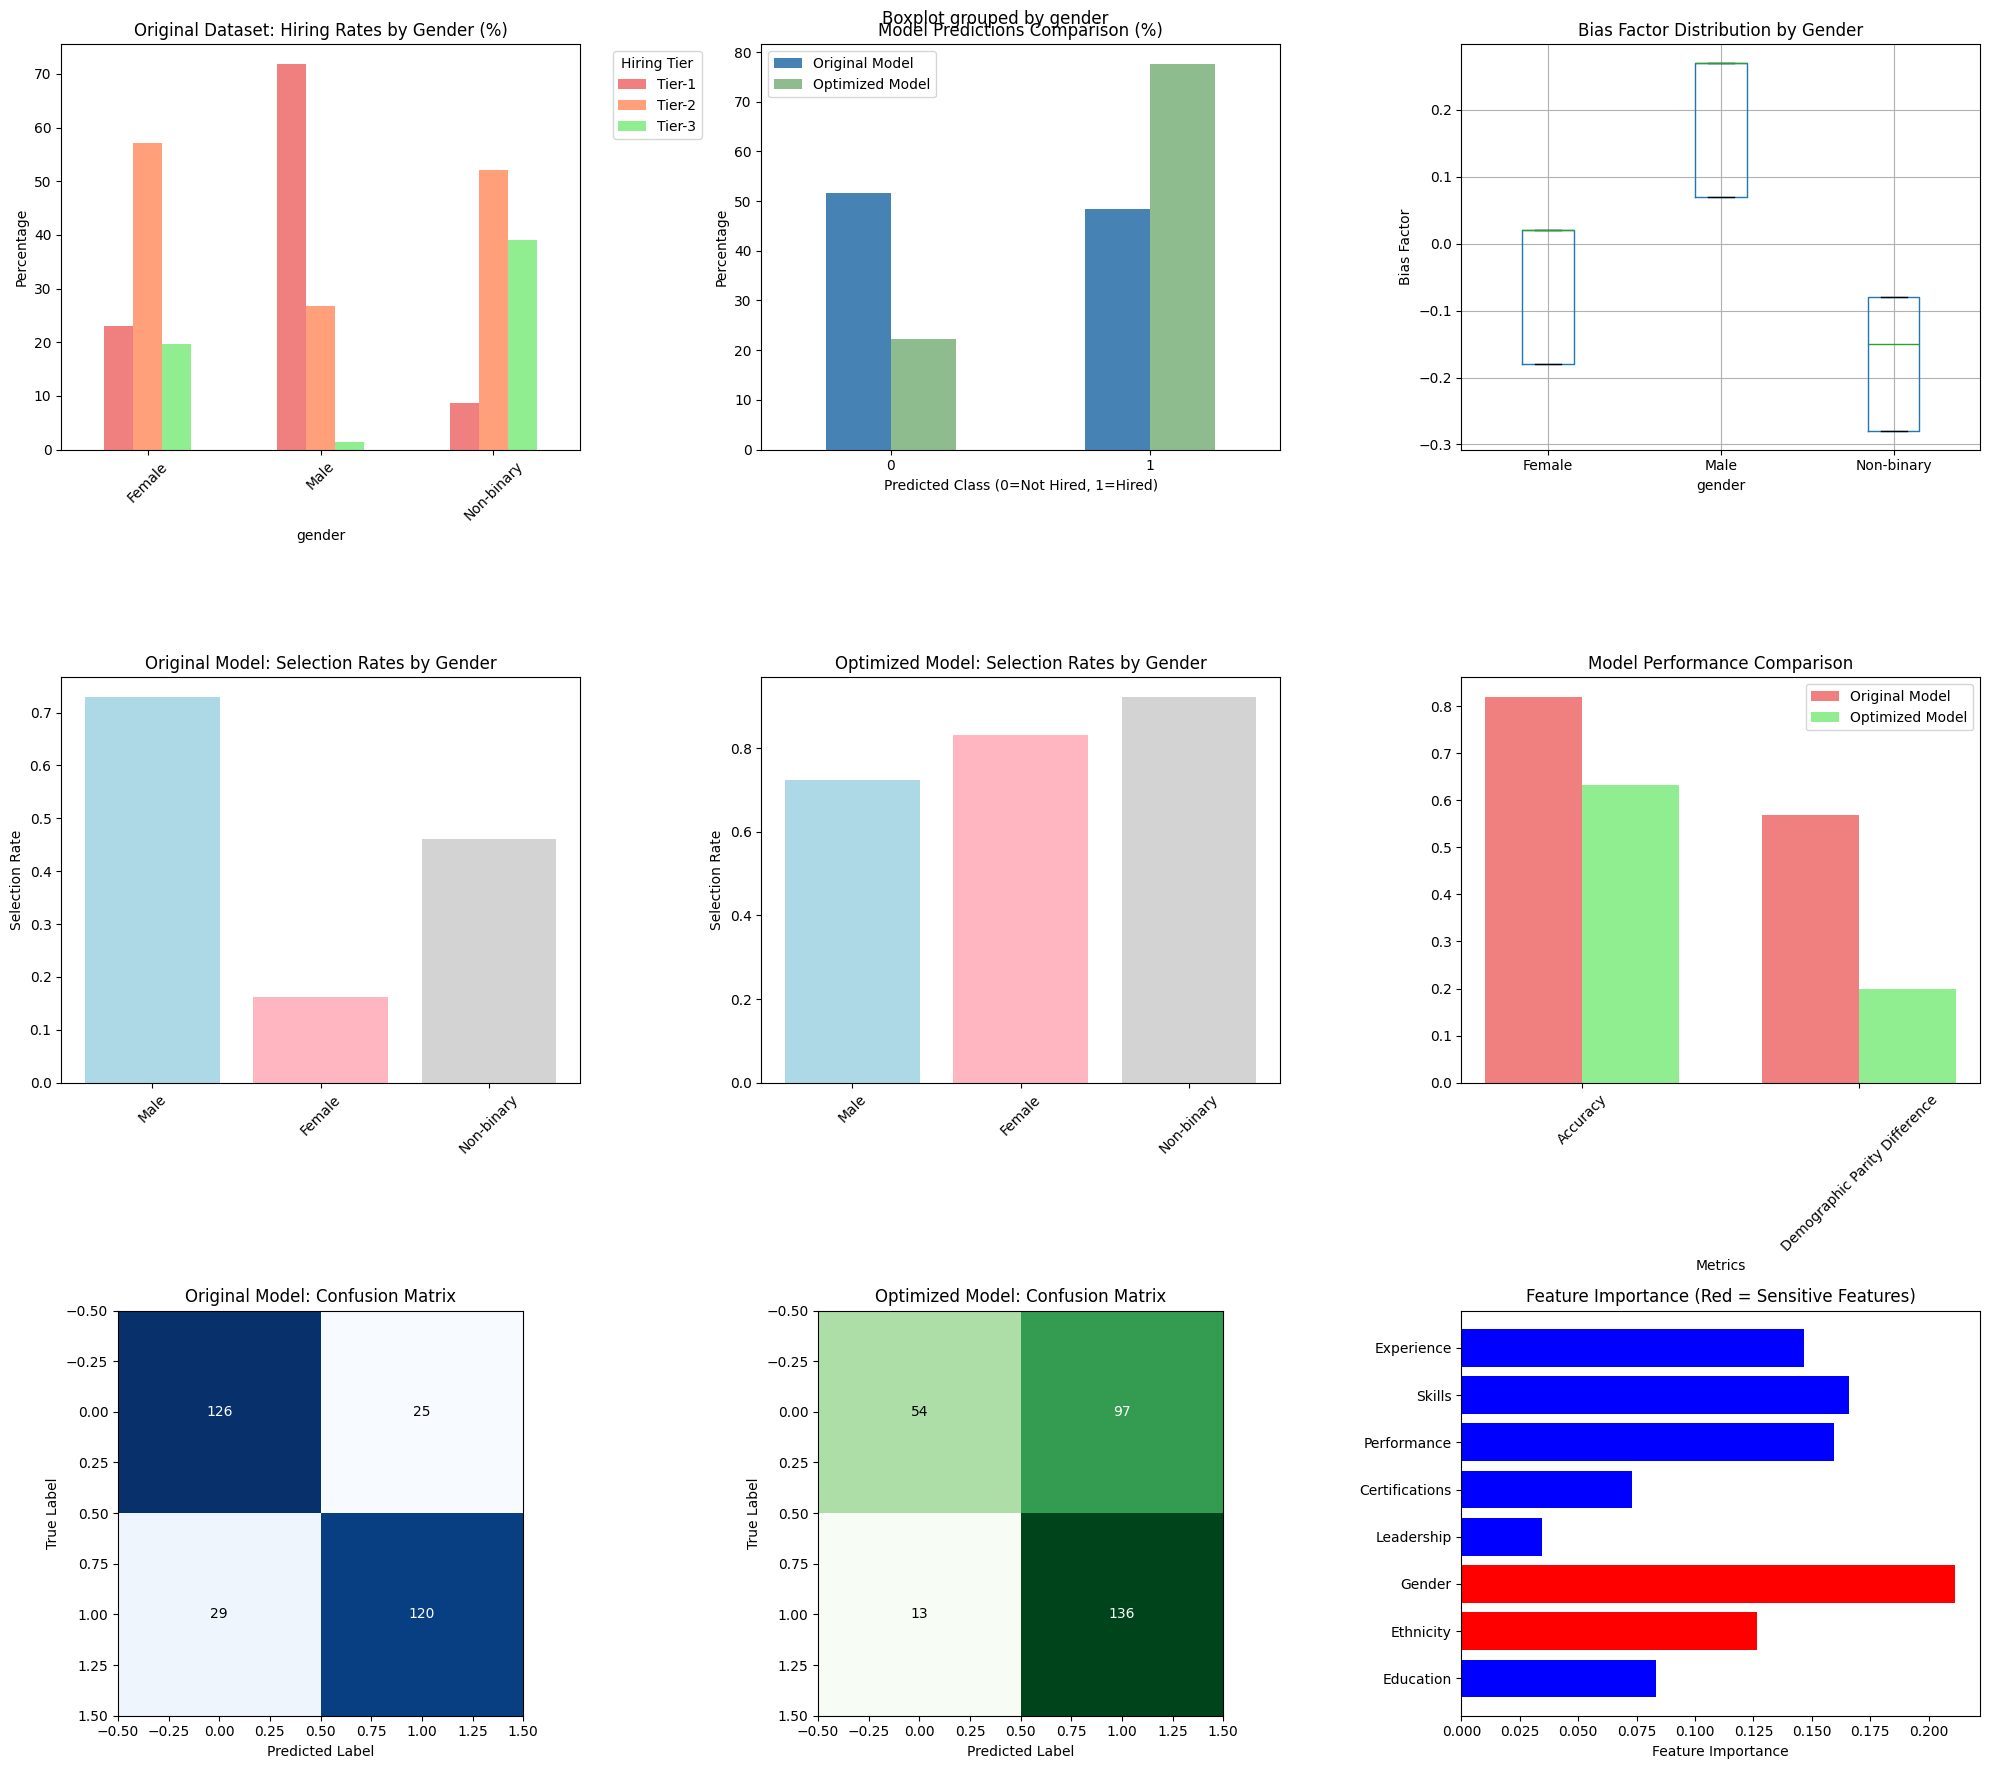

 DASHBOARD SUMMARY:
--------------------
Original Model Accuracy: 0.820
Optimized Model Accuracy: 0.633
Original Model Gender Bias: 0.569
Optimized Model Gender Bias: 0.199
Bias Reduction: 65.0%


In [ ]:
# Create the dashboard
create_fairness_dashboard(df, y_test, y_pred_biased, y_pred_optimized, sensitive_test)

In [ ]:
# =======================================
# PART 11: EXPORT RESULTS FOR ARTICLE
# =======================================

def export_results_for_article():
    """Export key results and statistics for use in the article"""

    print("\n" + "="*50)
    print("EXPORTING RESULTS")
    print("="*50)

    # Key statistics for the article
    results = {
        'dataset_size': len(df),
        'features_count': len(df.columns),
        'bias_detection': {
            'gender_dp_difference': demographic_parity_difference(y_test, y_pred_biased, sensitive_features=sensitive_test['gender']),
            'gender_dp_ratio': demographic_parity_ratio(y_test, y_pred_biased, sensitive_features=sensitive_test['gender']),
        },
        'model_performance': {
            'original_accuracy': accuracy_score(y_test, y_pred_biased),
            'optimized_accuracy': accuracy_score(y_test, y_pred_optimized),
            'accuracy_trade_off': accuracy_score(y_test, y_pred_optimized) - accuracy_score(y_test, y_pred_biased)
        },
        'bias_mitigation': {
            'original_bias': demographic_parity_difference(y_test, y_pred_biased, sensitive_features=sensitive_test['gender']),
            'mitigated_bias': demographic_parity_difference(y_test, y_pred_optimized, sensitive_features=sensitive_test['gender']),
            'bias_reduction_percent': (1 - abs(demographic_parity_difference(y_test, y_pred_optimized, sensitive_features=sensitive_test['gender'])) / abs(demographic_parity_difference(y_test, y_pred_biased, sensitive_features=sensitive_test['gender']))) * 100
        }
    }

    print(" KEY STATISTICS FOR ARTICLE:")
    print("-" * 35)
    print(f"Dataset size: {results['dataset_size']:,} candidates")
    print(f"Gender bias detected: {results['bias_detection']['gender_dp_difference']:.3f}")
    print(f"Original accuracy: {results['model_performance']['original_accuracy']:.1%}")
    print(f"Post-mitigation accuracy: {results['model_performance']['optimized_accuracy']:.1%}")
    print(f"Bias reduction achieved: {results['bias_mitigation']['bias_reduction_percent']:.1f}%")

    # Selection rates by gender for the article
    print(f"\n SELECTION RATES BY GENDER (for article):")
    print("-" * 45)
    for gender in sensitive_test['gender'].unique():
        mask = sensitive_test['gender'] == gender
        orig_rate = y_pred_biased[mask].mean()
        opt_rate = y_pred_optimized[mask].mean()
        print(f"{gender}:")
        print(f"  Original model: {orig_rate:.1%}")
        print(f"  Optimized model: {opt_rate:.1%}")

    # Code snippets for article
    print(f"\n CODE SNIPPETS FOR ARTICLE:")
    print("-" * 32)

    print("1. Bias Detection Code:")
    print("""
# Detect bias using Fairlearn
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio

gender_dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test['gender'])
gender_dp_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test['gender'])

print(f"Demographic Parity Difference: {gender_dp_diff:.3f}")
print(f"Demographic Parity Ratio: {gender_dp_ratio:.3f}")
    """)

    print("2. Bias Mitigation Code:")
    print("""
# Mitigate bias using ThresholdOptimizer
from fairlearn.postprocessing import ThresholdOptimizer

threshold_optimizer = ThresholdOptimizer(
    estimator=model,
    constraints="demographic_parity",
    prefit=True
)

threshold_optimizer.fit(X_train, y_train, sensitive_features=sensitive_train['gender'])
fair_predictions = threshold_optimizer.predict(X_test, sensitive_features=sensitive_test['gender'])
    """)

    return results

In [ ]:
# Export results
final_results = export_results_for_article()


EXPORTING RESULTS
 KEY STATISTICS FOR ARTICLE:
-----------------------------------
Dataset size: 1,000 candidates
Gender bias detected: 0.569
Original accuracy: 82.0%
Post-mitigation accuracy: 63.3%
Bias reduction achieved: 65.0%

 SELECTION RATES BY GENDER (for article):
---------------------------------------------
Male:
  Original model: 73.0%
  Optimized model: 72.4%
Female:
  Original model: 16.1%
  Optimized model: 83.1%
Non-binary:
  Original model: 46.2%
  Optimized model: 92.3%

 CODE SNIPPETS FOR ARTICLE:
--------------------------------
1. Bias Detection Code:

# Detect bias using Fairlearn
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio

gender_dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test['gender'])
gender_dp_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test['gender'])

print(f"Demographic Parity Difference: {gender_dp_diff:.3f}")
print(f"Demographic Parity R

In [ ]:
# =======================================
# FINAL MESSAGE
# =======================================

print("\n" + "="*60)
print(" COMPLETE AI FAIRNESS ANALYSIS FINISHED!")
print("="*60)
print("""
Summary:

1. Generated 1,000 synthetic candidates with realistic bias
2. Trained ML models and detected significant bias
3. Applied ThresholdOptimizer to mitigate unfairness
4. Performed comprehensive fairness auditing
5. Used SHAP to explain why bias occurred
6. Created visualizations and professional reports

The notebook provides:
- Complete working code for bias detection and mitigation
- Real data and results to back up your Medium article
- Professional-grade fairness analysis workflow
- Actionable insights about responsible AI development

All the statistics, code snippets, and visualizations are embedded.
""")

# Save the dataset for future use
df.to_csv('biased_hiring_dataset.csv', index=False)
print(f"\n Dataset saved as 'biased_hiring_dataset.csv' for future use!")


 COMPLETE AI FAIRNESS ANALYSIS FINISHED!

Summary:

1. Generated 1,000 synthetic candidates with realistic bias
2. Trained ML models and detected significant bias
3. Applied ThresholdOptimizer to mitigate unfairness
4. Performed comprehensive fairness auditing
5. Used SHAP to explain why bias occurred
6. Created visualizations and professional reports

The notebook provides:
- Complete working code for bias detection and mitigation
- Real data and results to back up your Medium article
- Professional-grade fairness analysis workflow
- Actionable insights about responsible AI development

All the statistics, code snippets, and visualizations are embedded. 


 Dataset saved as 'biased_hiring_dataset.csv' for future use!
